<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/08_linear_regression_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ケーススタディ： solubility data

Max Kuhn and Kjell Johnson. Applied Predictive Modeling. Springer, 2013. に出てくるデータセット (Section 6.1)

http://appliedpredictivemodeling.com/data

* 説明変数は下記の228個
 * Two hundred and eight binary “fingerprints” that indicate the presence or absence of a particular chemical substructure.
 * Sixteen count descriptors, such as the number of bonds or the number of bromine atoms.
 * Four continuous descriptors, such as molecular weight or surface area.

* 目的変数はlog solubility
 * 範囲は−11.6から1.6、平均は−2.7

### 1) 訓練データとテストデータを読む

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

In [2]:
PATH = '/content/drive/MyDrive/data/'

X = pd.read_csv(PATH + 'solTrainX.csv')
y = pd.read_csv(PATH + 'solTrainY.csv')['x']

X_test = pd.read_csv(PATH + 'solTestX.csv')
y_test = pd.read_csv(PATH + 'solTestY.csv')['x']

In [3]:
X.head()

,Unnamed: 0,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,FP011,FP012,FP013,FP014,FP015,FP016,FP017,FP018,FP019,FP020,FP021,FP022,FP023,FP024,FP025,FP026,FP027,FP028,FP029,FP030,FP031,FP032,FP033,FP034,FP035,FP036,FP037,FP038,FP039,...,FP189,FP190,FP191,FP192,FP193,FP194,FP195,FP196,FP197,FP198,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208,MolWeight,NumAtoms,NumNonHAtoms,NumBonds,NumNonHBonds,NumMultBonds,NumRotBonds,NumDblBonds,NumAromaticBonds,NumHydrogen,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
0,661,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,208.28,28,16,30,18,16,0,0,16,12,14,2,0,0,0,0,3,-0.856,25.78,25.78
1,662,0,1,0,1,1,1,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,365.54,49,26,52,29,13,4,0,12,23,21,3,1,1,0,0,4,-0.370,52.19,80.43
2,663,1,1,1,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,206.31,33,15,33,15,7,4,1,6,18,13,0,2,0,0,0,1,-0.330,37.30,37.30
3,665,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,136.26,26,10,26,10,2,1,2,0,16,10,0,0,0,0,0,1,-0.960,0.00,0.00
4,668,0,0,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229.75,31,15,31,15,6,5,0,6,16,9,5,0,0,1,1,1,-0.069,53.94,53.94


In [4]:
y.head()

0   -3.97
1   -3.98
2   -3.99
3   -4.00
4   -4.06
Name: x, dtype: float64

### 2) 連続値をとる20変数の様子をみる

* seabornで散布図を描く。
* もちろん訓練データを使う。
* 縦軸は目的変数とする。

In [5]:
# 連続値をとる変数の名前を取り出す
continuous = [s for s in X.columns.to_list() if s[:3] in ['Num', 'Hyd', 'Mol', 'Sur']]
print(len(continuous), 'continuous features')
print(continuous)

20 continuous features
['MolWeight', 'NumAtoms', 'NumNonHAtoms', 'NumBonds', 'NumNonHBonds', 'NumMultBonds', 'NumRotBonds', 'NumDblBonds', 'NumAromaticBonds', 'NumHydrogen', 'NumCarbon', 'NumNitrogen', 'NumOxygen', 'NumSulfer', 'NumChlorine', 'NumHalogen', 'NumRings', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2']


* 目的変数との関連を可視化する。

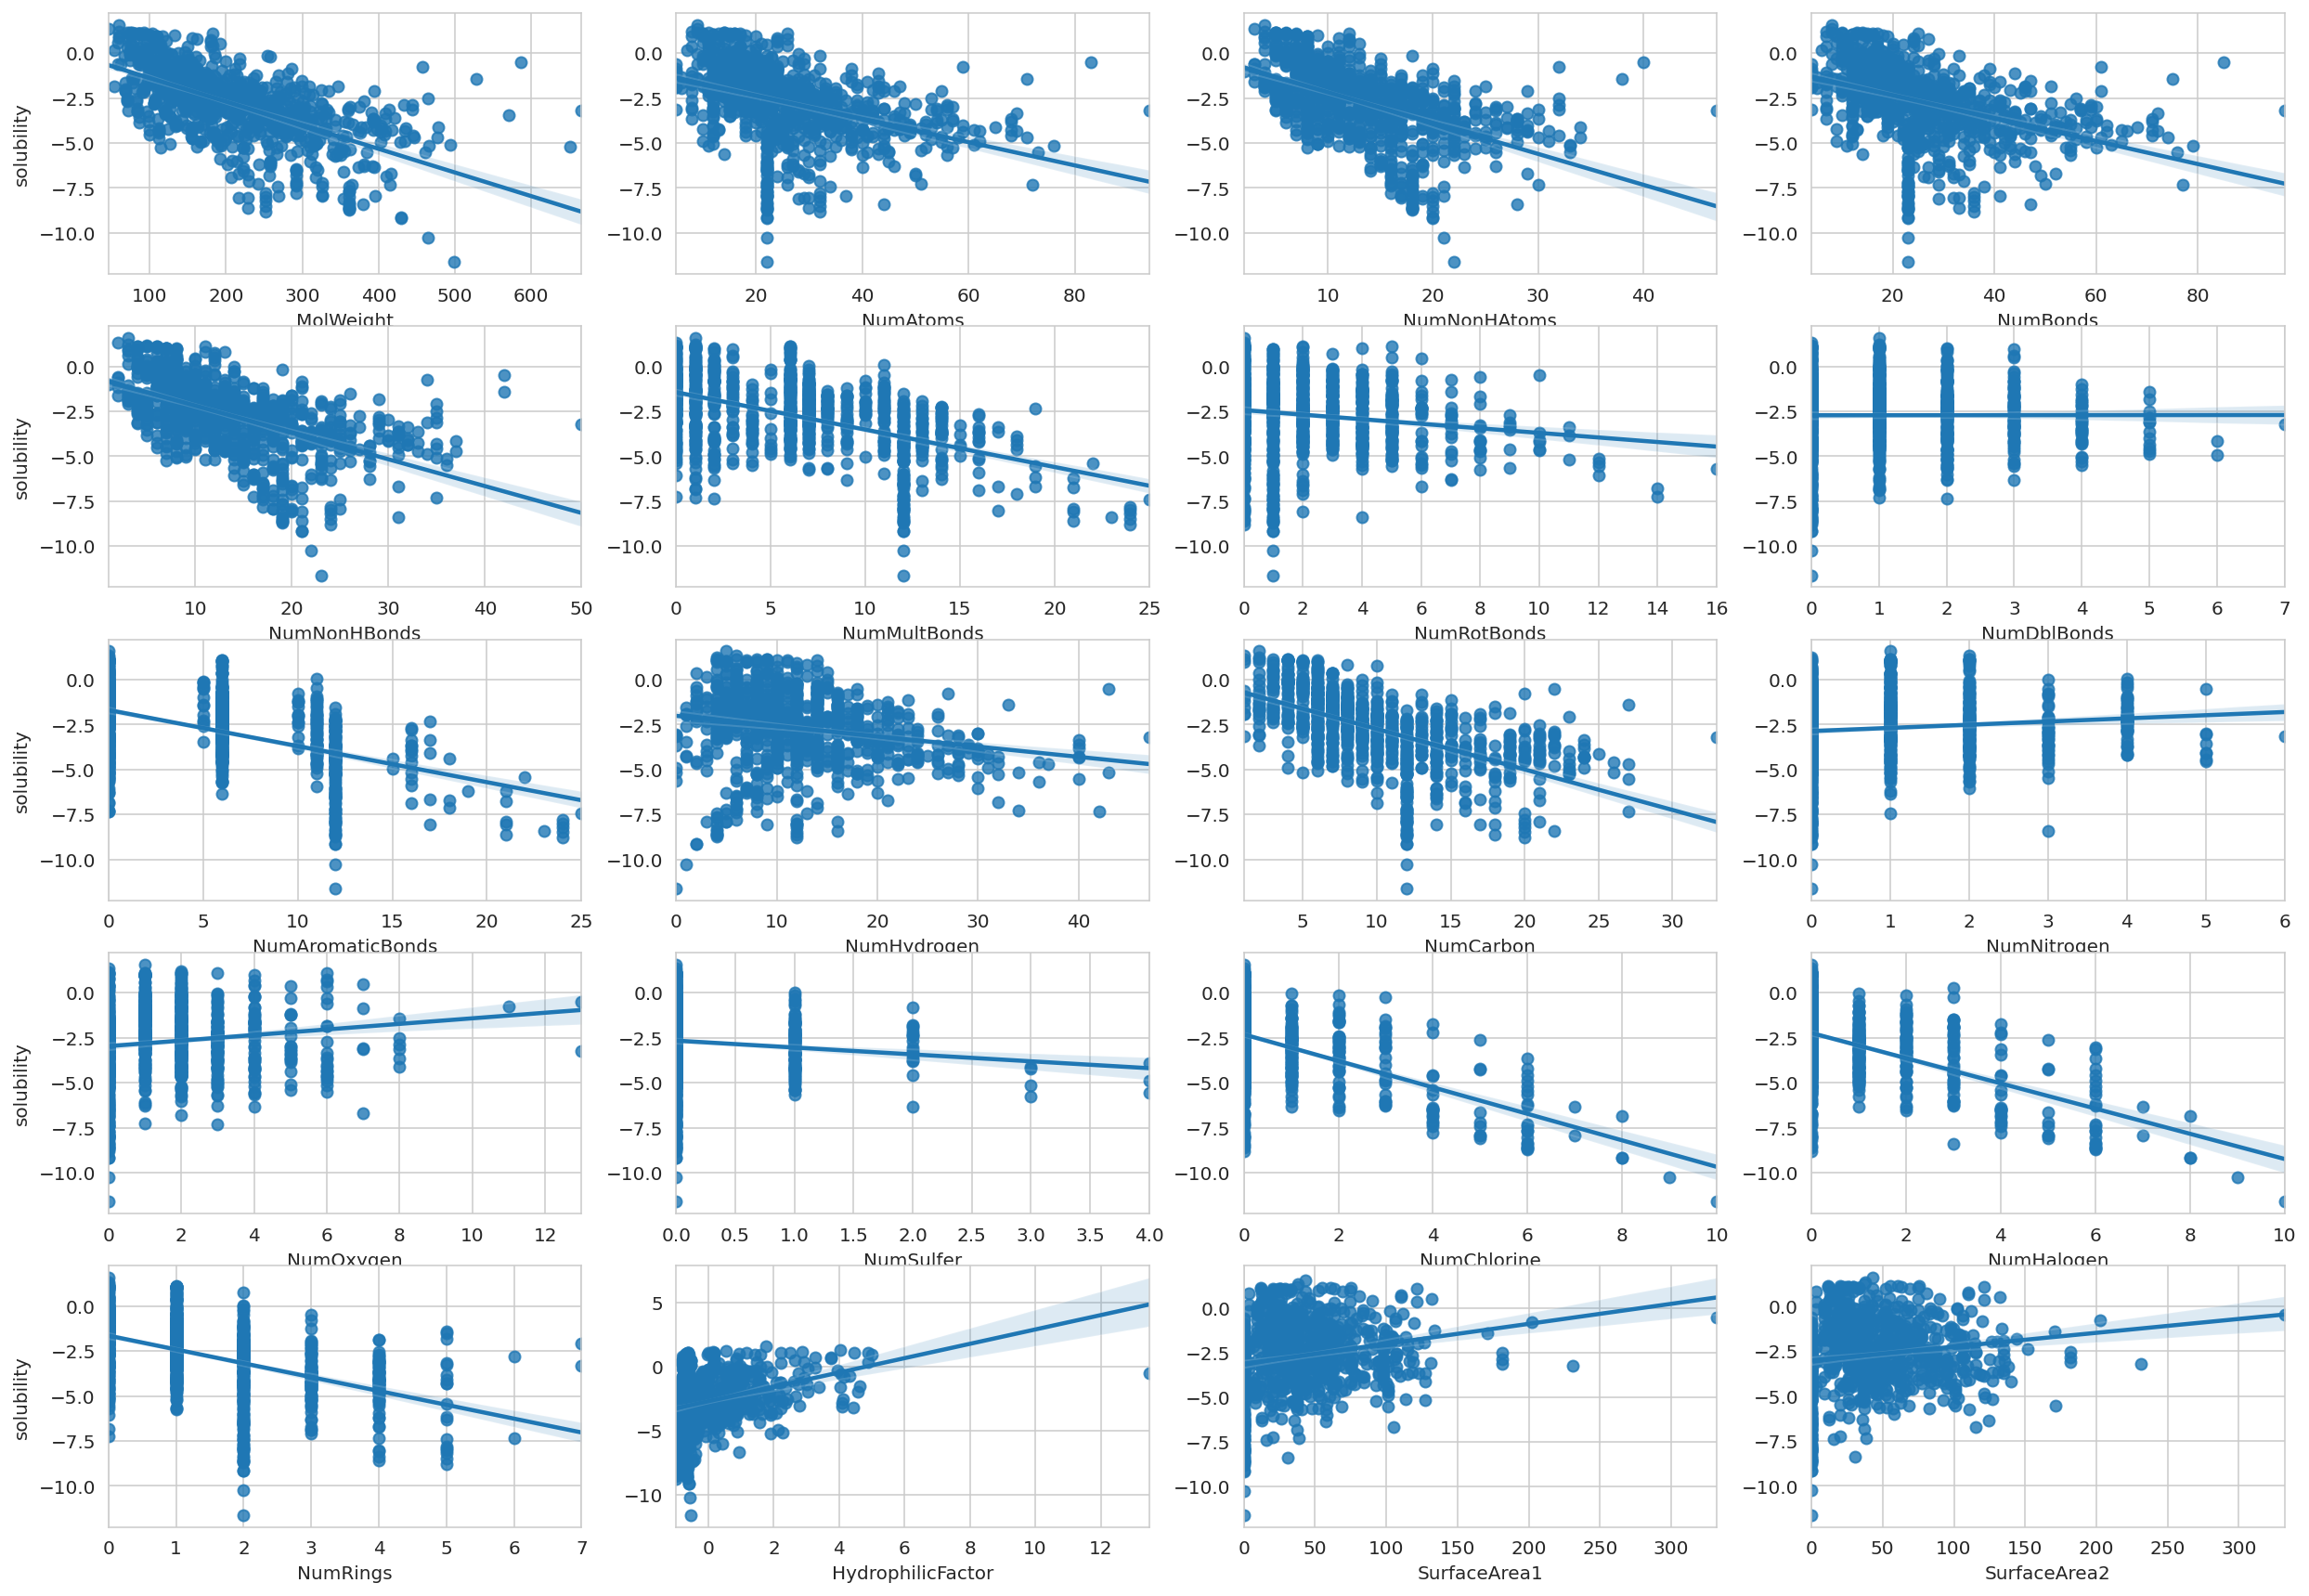

In [6]:
X['solubility'] = y # 図を描くために、一時的にこうしておく

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21, 15))
for i in range(20):
  ax = fig.add_subplot(5, 4, i+1)
  sns.regplot(x=continuous[i], y='solubility', data=X, ax=ax)
  if i % 4 != 0:
    ax.set_ylabel('')

X = X.drop('solubility', axis=1) # 図を描き終えたので、元に戻す

### 3) ２値変数の部分の雰囲気を見る

In [7]:
binary = X.columns[X.columns.str.startswith('FP')].to_list()
print(len(binary), 'binary features')
X[binary].describe()

208 binary features


,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,FP011,FP012,FP013,FP014,FP015,FP016,FP017,FP018,FP019,FP020,FP021,FP022,FP023,FP024,FP025,FP026,FP027,FP028,FP029,FP030,FP031,FP032,FP033,FP034,FP035,FP036,FP037,FP038,FP039,FP040,...,FP169,FP170,FP171,FP172,FP173,FP174,FP175,FP176,FP177,FP178,FP179,FP180,FP181,FP182,FP183,FP184,FP185,FP186,FP187,FP188,FP189,FP190,FP191,FP192,FP193,FP194,FP195,FP196,FP197,FP198,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,...,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,0.493165,0.539432,0.436383,0.584648,0.579390,0.400631,0.363828,0.325973,0.279706,0.178759,0.214511,0.176656,0.166141,0.160883,0.860147,0.146162,0.144059,0.131441,0.121977,0.119874,0.120925,0.104101,0.123028,0.112513,0.115668,0.084122,0.097792,0.106204,0.101998,0.093586,0.089380,0.073607,0.069401,0.079916,0.072555,0.075710,0.070452,0.086225,0.074658,0.068349,...,0.186120,0.184017,0.169295,0.151420,0.141956,0.130389,0.134595,0.121977,0.120925,0.120925,0.097792,0.107256,0.093586,0.098843,0.075710,0.084122,0.085174,0.076761,0.072555,0.068349,0.076761,0.072555,0.070452,0.060988,0.062040,0.058885,0.060988,0.056782,0.052576,0.056782,0.047319,0.049422,0.052576,0.257624,0.114616,0.098843,0.077813,0.059937,0.056782,0.112513
std,0.500216,0.498705,0.496197,0.493042,0.493917,0.490284,0.481353,0.468984,0.449091,0.383352,0.410699,0.381578,0.372403,0.367617,0.347017,0.353454,0.351334,0.338059,0.327431,0.324985,0.326212,0.305552,0.328643,0.316163,0.319994,0.277717,0.297189,0.308261,0.302805,0.291405,0.285441,0.261267,0.254268,0.271306,0.259541,0.264672,0.256042,0.280844,0.262977,0.252477,...,0.389408,0.387702,0.375210,0.358646,0.349188,0.336908,0.341470,0.327431,0.326212,0.326212,0.297189,0.309601,0.291405,0.298609,0.264672,0.277717,0.279287,0.266352,0.259541,0.252477,0.266352,0.259541,0.256042,0.239435,0.241355,0.235534,0.239435,0.231548,0.223303,0.231548,0.212431,0.216861,0.223303,0.437556,0.318726,0.298609,0.268018,0.237495,0.231548,0.316163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### 4) 2値の部分と連続値の部分をあわせた元のデータに、単純に線形回帰を適用

* 線形回帰を動かす前に、検証データを取り出しておく

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

* 2値の説明変数と連続値の説明変数を連結して、訓練データ全体を作る

In [9]:
X_train = pd.concat([X_train[binary], X_train[continuous]], axis=1)

* 線形回帰モデルのパラメータを最小二乗法で推定させる


In [10]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

* 検証データでの予測を評価する


In [11]:
X_valid = pd.concat([X_valid[binary], X_valid[continuous]], axis=1)
y_valid_pred = reg.predict(X_valid)
print('RMSE:', mean_squared_error(y_valid, y_valid_pred, squared=False))

RMSE: 0.6570505787632186


* このRMSEを改善できるかどうか、いろいろ試行錯誤する。

---

### 5) PCAを使って2値の部分だけ次元を落としてみる

In [12]:
from sklearn.decomposition import PCA

n_components = 100 # 使用する主成分の個数
pca = PCA(n_components=n_components, random_state=123) # random_stateは入れておいたほうがいいようだ
pca.fit(X_train[binary])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=123,
    svd_solver='auto', tol=0.0, whiten=False)

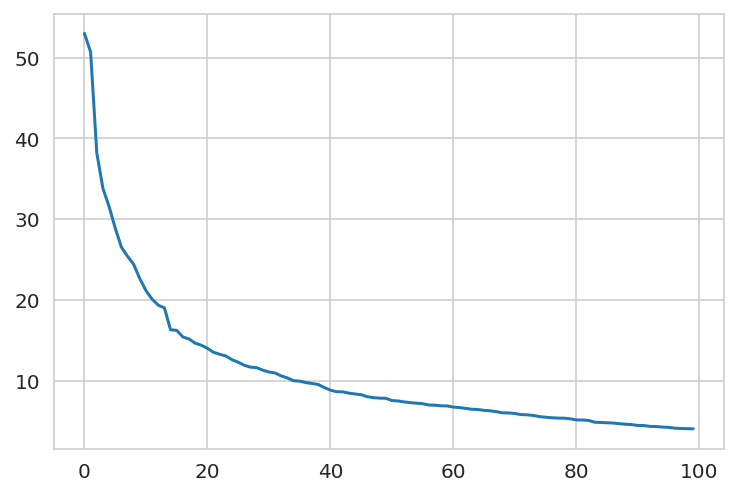

In [13]:
plt.plot(range(n_components), pca.singular_values_)

In [14]:
X_train_binary = X_train[binary]
X_train_binary_embedded = pca.transform(X_train_binary)

In [15]:
X_train_binary_embedded[0]

array([ 1.65124652e+00,  2.20555259e+00, -1.09629565e-01, -7.90365832e-01,
       -9.79572592e-01,  3.51703942e-01,  1.52232474e+00,  1.08112309e+00,
       -1.94580834e-01, -5.96888262e-01, -2.24493749e-01,  1.68565912e-01,
        9.59370426e-01, -1.44669048e+00,  5.18748091e-02,  7.53452027e-01,
        1.89751293e-01,  5.86278995e-01, -4.48451102e-02, -7.42056263e-01,
        8.77553107e-01, -1.44020436e-01, -6.28629919e-01,  1.63014826e+00,
       -5.73014624e-01,  3.03871044e-01, -4.69353499e-01,  1.17528665e+00,
        1.03486178e+00, -2.13017119e-01,  2.20373653e-01, -2.06098939e-01,
       -2.24845634e-01,  9.54024080e-01, -1.30898066e+00, -1.67562261e-03,
        5.73626820e-02,  2.82729539e-01,  9.65866355e-01, -7.99700270e-01,
        2.37126348e-01, -3.86682403e-02,  6.60140168e-02, -1.32777780e-02,
        6.08357999e-01, -5.45539703e-01, -6.16492157e-01, -5.85473662e-01,
       -1.01627373e-01,  6.10258455e-02,  3.06948895e-01, -6.32681898e-01,
       -3.75106836e-01,  

* 2値変数の部分を次元削減した後のものと、元の連続値の部分とを、くっつける


In [16]:
X_train_embedded = np.concatenate([X_train_binary_embedded, X_train[continuous]], 1)

* X_train_embeddedを使って線形回帰モデルのパラメータを決める
* そして検証データでの予測スコアを求める
 * もちろん、検証データの2値の部分も、次元削減する必要があります。


In [17]:
reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_valid_binary_embedded = pca.transform(X_valid[binary])
X_valid_embedded = np.concatenate([X_valid_binary_embedded, X_valid[continuous]], 1)
y_valid_pred = reg.predict(X_valid_embedded)
print('RMSE:', mean_squared_error(y_valid, y_valid_pred, squared=False))

RMSE: 0.6482754405370651


* ほんの少しだけ、良くなっている。

### 6) ２値変数のインタラクションを考慮してみる

* PolynomialFeaturesを2次の設定で使う
* その上で主成分分析を適用

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly.fit(X_train_binary)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                   order='C')

In [19]:
X_train_binary_poly = poly.transform(X_train_binary)

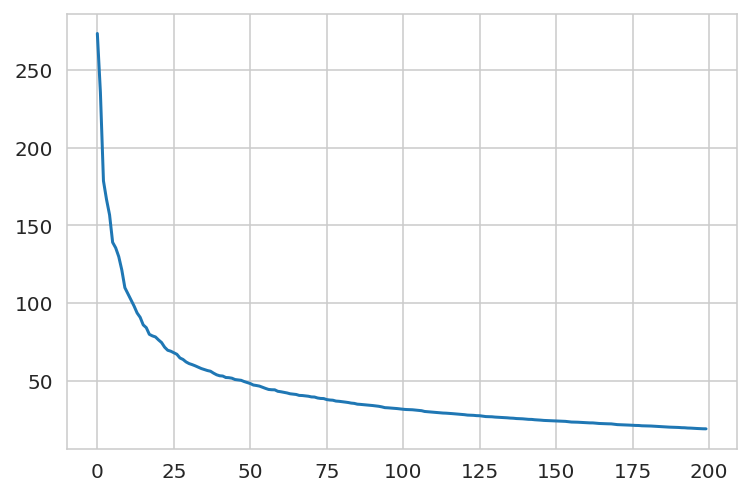

In [20]:
n_components = 200
pca = PCA(n_components=n_components, random_state=123) 
pca.fit(X_train_binary_poly)
plt.plot(range(n_components), pca.singular_values_)

* 2次のインタラクションを含めた2値変数の部分を次元削減した後のものと、元の連続値の部分とを、くっつける


In [21]:
X_train_embedded = np.concatenate([pca.transform(X_train_binary_poly),
                                   X_train[continuous]], 1)

In [22]:
reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_valid_binary_poly_embedded = pca.transform(poly.transform(X_valid[binary]))
X_valid_embedded = np.concatenate([X_valid_binary_poly_embedded, X_valid[continuous]], 1)
y_valid_pred = reg.predict(X_valid_embedded)
print('RMSE:', mean_squared_error(y_valid, y_valid_pred, squared=False))

RMSE: 0.5750369484566087


かなり良くなっている。

### 7) Ridge回帰を使う

* alphaをチューニングする。

In [23]:
from sklearn.linear_model import Ridge

for alpha in 10. ** np.arange(-5, 6):
  reg = Ridge(alpha=alpha)
  reg.fit(X_train_embedded, y_train)
  y_valid_pred = reg.predict(X_valid_embedded)
  print('alpha: {}; RMSE: {:.4f}'.format(alpha, mean_squared_error(y_valid, y_valid_pred, squared=False)))

alpha: 1e-05; RMSE: 0.5751
alpha: 0.0001; RMSE: 0.5751
alpha: 0.001; RMSE: 0.5750
alpha: 0.01; RMSE: 0.5747
alpha: 0.1; RMSE: 0.5726
alpha: 1.0; RMSE: 0.5680
alpha: 10.0; RMSE: 0.5712
alpha: 100.0; RMSE: 0.5865
alpha: 1000.0; RMSE: 0.6372
alpha: 10000.0; RMSE: 0.7900
alpha: 100000.0; RMSE: 0.9912


### 8) ここまで一番良かった手法で最終評価

* ここまででは、Ridge回帰のalpha=1.0が最も良かった（検証データのRMSEが0.5680）。
* そこで、この手法を採用して、テストデータで最終評価する。


In [24]:
reg = Ridge(alpha=1.0)
reg.fit(X_train_embedded, y_train)

X_test_binary_poly_embedded = pca.transform(poly.transform(X_test[binary]))
X_test_embedded = np.concatenate([X_test_binary_poly_embedded, X_test[continuous]], 1)
y_test_pred = reg.predict(X_test_embedded)
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE: 0.7075896856472644


* それほど良くはない。
検証データでの評価結果と大きな差があるようだ。

# 課題8
* solubilityデータセットの、上で作った検証データに対して、できるだけ予測性能の良いモデルを見つけよう
 * Ridge回帰やLassoを使ってもいいです。
 * 特徴量はどのように加工してもいいです。（上では2値変数にPCAを使った）
* 検証データを使って見つけた最も良いモデルを、最後に一回、テストデータで評価してみよう

（ここから試行錯誤してみてください。）